Data cleaning and linear regression practice: House Sales in King County.

Terence Egbelo (TE): I found this rather interesting dataset on Kaggle; it contains public-domain data on property sales in King County, Washington state, USA, from 2014 and 2015.

I used the dataset to practice data cleaning with pandas and to experiment with linear regression using sklearn.

In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [60]:
houses = pd.read_csv('kc_house_data.csv')

In [61]:
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


TE: Perhaps the first thing that jumps out from this DataFrame are the values in the `date` column.
The date and time are recorded all together in a string. Let's find out for sure.

In [62]:
houses.date.dtype

dtype('O')

TE: Indeed the data type of the `date` column is 'object'.

It appears all characters after the `T` might be `0`s - an additional string to record time but without differentiating data.

Let's make sure this is the case, and if it is, remove the `0`s along with the `T`s, and then convert the column to a `datetime` format we can work with a bit more easily (for example, if wishing to filter by month).

In [63]:
houses[houses.date.str.contains('^000000')]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


TE: We can confirm that no values in `date` contain any sequence after the `T` other than `000000`.
It is thus safe to split out this sequence into a new column.

In [64]:
houses['split'] = houses.date.str.split('T')
houses['true_date'] = houses.split.str.get(0)
houses['time'] = houses.split.str.get(1)

TE: Let's inspect the edited `houses` to see where the new columns are located!

In [65]:
houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'split', 'true_date',
       'time'],
      dtype='object')

TE: The new columns have been inserted right at the end of `houses`. We would like to end up with the cleaned `true_date` column in place of `date` and remove `split` and `time` - let's do that.

In [66]:
# First, let's drop `date`, 'split' and 'time'
houses = houses.drop(columns=['date','split','time'])

In [67]:
# Now, let's rename `true_date` to `date`
houses = houses.rename(columns={'true_date':'date'})

In [68]:
# Making sure the changes are taking place as intended:
houses.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date'],
      dtype='object')

In [69]:
# Finally, let's re-order the remaining columns so that our new `date` is in place of the old `date` column.
columns_to_order = ['id', 'date']
new_columns = columns_to_order + houses.columns.drop(columns_to_order).tolist()
houses = houses[new_columns]
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


TE: Now, we can finally change the `dtype` of `date`, making it much easier to query `houses` based on date!

In [70]:
houses.date = houses.date.astype('datetime64[ns]')

In [71]:
# For instance, we can now filter the dataset by month, say May:
houses[houses['date'].dt.month == 5].sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18138,8691330910,2014-05-21,744000.0,4,2.75,2830,13059,2.0,0,0,...,10,2830,0,1998,0,98075,47.5950,-121.986,3840,11596
8126,2787460720,2015-05-06,259950.0,3,2.00,1010,7896,1.0,0,0,...,7,1010,0,1984,0,98031,47.4046,-122.181,1540,7896
21263,4014400381,2014-05-07,495000.0,4,2.75,2656,21195,2.0,0,0,...,9,2656,0,2014,0,98001,47.3162,-122.272,1860,16510
17235,1338600225,2014-05-28,1970000.0,8,3.50,4440,6480,2.0,0,3,...,10,3140,1300,1959,0,98112,47.6310,-122.303,4440,8640
20472,5057100110,2015-05-14,479349.0,5,3.00,3223,6371,2.0,0,0,...,9,3223,0,2014,0,98042,47.3584,-122.163,1979,9008


In [72]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [73]:
lin_regr = LinearRegression()

TE: Before running a regression let's look at the correlations between `price` and the independent variables in the dataset (excluding `id` and `date`)

In [74]:
price_correlations = houses.loc[:, 'price':'sqft_lot15'].\
       corr()['price'].\
       sort_values(ascending=False).reset_index()

print(price_correlations)

            index     price
0           price  1.000000
1     sqft_living  0.702035
2           grade  0.667434
3      sqft_above  0.605567
4   sqft_living15  0.585379
5       bathrooms  0.525138
6            view  0.397293
7   sqft_basement  0.323816
8        bedrooms  0.308350
9             lat  0.307003
10     waterfront  0.266369
11         floors  0.256794
12   yr_renovated  0.126434
13       sqft_lot  0.089661
14     sqft_lot15  0.082447
15       yr_built  0.054012
16      condition  0.036362
17           long  0.021626
18        zipcode -0.053203


TE: We can see some usual suspects at the top! For example `sqft_living` (floor space) correlates strongly with `price`. Interestingly, `price` moves much less closely with `view` and `waterfront` - unexpected for an area in scenic Washington state!

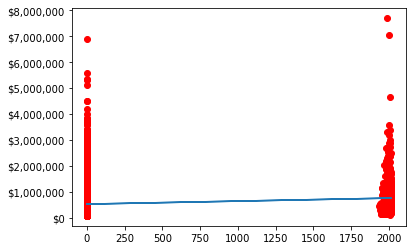

In [75]:
# Reshaping the columns to prepare them for linear regression:
year_renovated = np.array(houses.yr_renovated).reshape(-1,1)
price = np.array(houses.price).reshape(-1,1)

lin_regr.fit(year_renovated, price)
renovation_predict = lin_regr.predict(year_renovated)

import matplotlib.ticker as mtick
ax = plt.subplot()
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.scatter(year_renovated, price, color='red')
plt.plot(year_renovated, renovation_predict)
plt.show()

TE: What's happening here? Apparently, there are lots of houses that were renovated in Year 0!
More likely, these `0`s reflect missing renovation year values.
We'll need to exclude them from the regression.

In [76]:
# Let's quickly check how many of these rows we're dealing with:
houses[houses['yr_renovated'] == 0].yr_renovated.count()

20699

TE: Properties without a renovation date comprise about 95% of our dataset! This still leaves just under 1000 data points to run our linear regression `price` on `yr_renovated`. We may find a meaningful relationship yet.

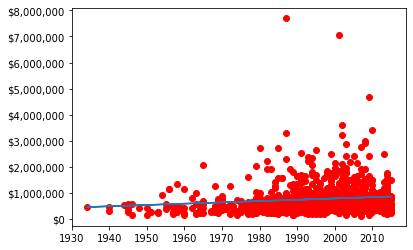

In [95]:
# First, modifying our data selection so only properties with real renovation dates are included:
renovated_houses_yr_df = houses[houses['yr_renovated'] != 0].reset_index(drop=True)

# Reshaping our series again:
renovated_houses_yr = np.array(renovated_houses_yr_df.yr_renovated).reshape(-1,1)
price = np.array(renovated_houses_yr_df.price).reshape(-1,1)

# Refitting and plotting the model:
lin_regr.fit(renovated_houses_yr, price)
renovation_predict = lin_regr.predict(renovated_houses_yr)

ax=plt.subplot()
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.scatter(renovated_houses_yr, price, color='red')
plt.plot(renovated_houses_yr, renovation_predict)
plt.show()

TE: Just glancing at the result it appears there is an extremely weak positive relationship between property price and year of renovation. We can demonstrate this concretely by plugging specific values for `yr_renovated` into our regression model:

In [ ]:
lin_regr.predict(np.array([1950,1970,1990,2010]).reshape(-1,1))

In [96]:
# Clearly there is a lot of error between the predicted and actual price.
# This is reflected in the R^2 score of this model:

print(lin_regr.score(renovated_houses_yr, price))

# Year of renovation is quite a weak predictor of property price in this dataset!

0.01635687509327488


TE: Let's build a more complete multiple linear regression model from our data and see how much variation in property prices can be explained by multiple other variables.

This time I will incorporate a train-test split for better model evaluation.

In [30]:
# First, to select the independent variables; let's pull up the correlation series for price again:

print(price_correlations)

            index     price
0           price  1.000000
1     sqft_living  0.702035
2           grade  0.667434
3      sqft_above  0.605567
4   sqft_living15  0.585379
5       bathrooms  0.525138
6            view  0.397293
7   sqft_basement  0.323816
8        bedrooms  0.308350
9             lat  0.307003
10     waterfront  0.266369
11         floors  0.256794
12   yr_renovated  0.126434
13       sqft_lot  0.089661
14     sqft_lot15  0.082447
15       yr_built  0.054012
16      condition  0.036362
17           long  0.021626
18        zipcode -0.053203


In [93]:
# Let's only select variables with correlation to price greater/less than +-0.2:

mult_regr_vars = houses[price_correlations.loc[1:11, 'index']]

In [81]:
mult_regr_vars.sample(5)

,sqft_living,grade,sqft_above,sqft_living15,bathrooms,view,sqft_basement,bedrooms,lat,waterfront,floors
4875,2130,8,2130,1910,2.25,0,0,4,47.6271,0,2.0
54,2730,8,2130,2730,2.25,0,600,5,47.6571,0,1.5
15505,1870,8,1670,1710,1.75,0,200,4,47.6435,0,1.0
16080,1280,6,840,1660,1.00,0,440,2,47.5532,0,1.0
18374,1600,7,1600,1700,2.50,0,0,3,47.3303,0,2.0


In [82]:
price.shape

(914, 1)

In [98]:
# We can see above that the price array is still adapted for the previous regression. Let's create a new
# variable for the full set of price values:

price_full = houses.price
print(len(price_full), len(mult_regr_vars))

21613 21613


In [89]:
# Looking good. Now to import the train-test split funtction:

from sklearn.model_selection import train_test_split

In [85]:
# To automate the process as much as possible, let's write a function that runs, evaluates and visualises\
# the regression, taking an array of independent variables and their vales as input:

def regress(dependent, independent, label_actual, label_predicted):
    
    # Preparing the training and testing datasets:
    x_train, x_test, y_train, y_test = \
    train_test_split(independent, dependent, test_size=0.2, random_state=1)
    
    # Accommodating one-dimensional independent variable arrays:
    if len(independent.shape) < 2:
        x_train = np.array(x_train).reshape(-1,1)
        x_test = np.array(x_test).reshape(-1,1)
    
    # Fitting and scoring the model:
    lin_regr = LinearRegression()
    
    lin_regr.fit(x_train, y_train)
    
    print('Train Score:', lin_regr.score(x_train,y_train))
    print('Test Score:', lin_regr.score(x_test,y_test))
    
    # For multiple linear regressions, the following block creates a sorted DataFrame listing 
    # independent variables and their coefficients; for simple regressions it simply prints the coefficient:
    
    if len(independent.shape) < 2:
        print(lin_regr.coef_)
        
    else:    
        variables = list(independent.columns)
        coefficients = np.split(lin_regr.coef_, len(independent.columns),axis=0)
    
        coef_df = {'Variable': variables, 'Coeff': coefficients}
        print(pd.DataFrame(coef_df).\
          sort_values(by='Coeff', ascending=False))
    
    # Visualisation:
    y_predicted = lin_regr.predict(x_test)
    
    plt.scatter(y_test,y_predicted)
    plt.xlabel(label_actual)
    plt.ylabel(label_predicted)
    plt.show()

Train Score: 0.6609804505193304
Test Score: 0.6460259272137385
         Variable                  Coeff
8             lat    [676669.3250414433]
9      waterfront    [563257.5890126154]
1           grade      [82021.124882056]
5            view    [65100.48598815526]
0     sqft_living   [124.97182899576852]
2      sqft_above   [62.599464072549495]
6   sqft_basement   [62.372364946207206]
3   sqft_living15    [5.066030935444611]
4       bathrooms   [-7046.114773327447]
7        bedrooms   [-23064.50014392017]
10         floors  [-25112.977888138543]


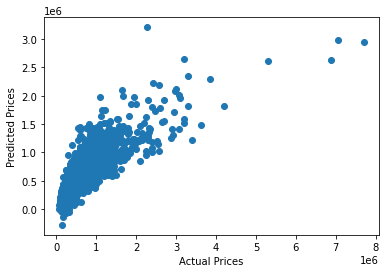

In [99]:
regress(price_full, mult_regr_vars, 'Actual Prices', 'Predicted Prices')

TE: Given the limited information from our variables (there are key details about each property but nothing about the wider community and surroundings such as transport links, quality and choice of schools, crime, entertainment, outdoor activity options etc.), this model approaches a decent R^2 score!

Train Score: 0.27189605789257176
Test Score: 0.2851049668514104
[241167.27057411]


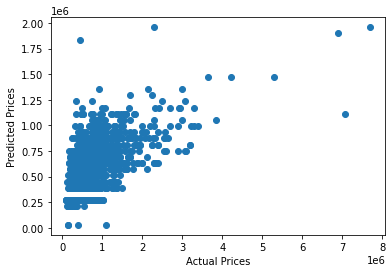

In [100]:
# What about price and number of bathrooms?

regress(price_full, houses.bathrooms, 'Actual Prices', 'Predicted Prices')

TE: Below is an interesting one. Properties further north command higher prices than in the south of King County. However, linear regression overpredicts the impact.

Notice the huge coeffecient - because latitude is given in degrees, which correspond to great distances, the impact of a 1 degree change north or south correlates with huge price changes.

Given the complex effects of location on property values, combining numerous natural and human factors, latitude is in all likelihood far too simplistic as an explanatory variable.

Train Score: 0.10078748780560731
Test Score: 0.07465063304230424
[809813.40063728]


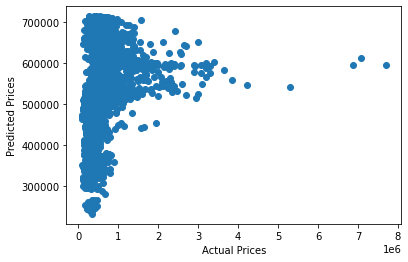

In [101]:
regress(price_full, houses.lat, 'Actual Prices', 'Predicted Prices')

TE: What if we considered another potential dependent variable? Basement space, for example? What variables could be good predictors in that case..?

In [88]:
houses.corr()['sqft_basement'].sort_values(ascending=False).head(10)

sqft_basement    1.000000
sqft_living      0.435043
price            0.323816
bedrooms         0.303093
bathrooms        0.283770
view             0.276947
sqft_living15    0.200355
condition        0.174105
grade            0.168392
lat              0.110538
Name: sqft_basement, dtype: float64

TE: Not very impressive correlations! This suggests basement size is a relatively idiosyncratic quantity - similar amounts of basement floor space can accompany disparate values of the other variables.

After all, people with a need for more or fewer bathrooms, placing a greater or lesser premium on a scenic view can all value extra room downstairs similarly - whether for wine, hoarding or a man cave!

Thanks for reading!